## Modules

In [1]:
import os
from tqdm import tqdm

import numpy as np
from scipy.ndimage import gaussian_filter, uniform_filter

from scipy.stats import sem
# from signal_analysis import SignalAnalysis

import seaborn as sns
import seaborn_image as isns
from matplotlib import pyplot as plt

from PIL import Image
import tifffile as tff

# cmap = 'cmc.batlow'
# sns.set_palette(cmap)

## 2D (timeseries)

### Open data

In [14]:
pathBase = r"C:\Users\gabri\Desktop\testAnalyse\2024_07-18"

data = np.loadtxt(pathBase + "\\785std.csv", skiprows=1, delimiter=',')
vein1 = data[:, 1]
vein2 = data[:, 2]
still1 = data[:, 3]
still2 = data[:, 4]

ts = np.load(pathBase + "\\785ts.npy")

### AP timeseries

In [15]:
FPS = 50
AP_idx = []
nChannels=5
AP_begin = 5
percycle=15
FPSc = FPS/nChannels
framespcycles = int(FPSc*percycle)
ncycles = int(len(ts)//framespcycles)
AP_times = np.array(list(range(ncycles)))*15+5

for ti in AP_times:
    AP_idx.append(np.argmin(np.absolute(ts-ti)))

# Dirac où AP dans times series
AP_series = np.zeros(len(ts))
AP_series[AP_idx] = 1

### Plot

(0.0, 100.0)

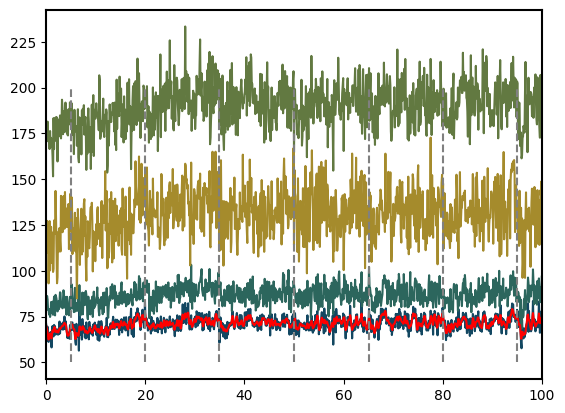

In [23]:
plt.plot(ts, vein1)
plt.plot(ts, vein2)
plt.plot(ts, still1-50)
plt.plot(ts, still2-100)
plt.plot(ts, gaussian_filter(vein1, sigma=1), color='red')
plt.vlines(ts[AP_idx], 50, 200, color='grey', linestyles='--')
plt.xlim(0, 100)

## 3D (frames)

### Open data

In [2]:
def identify_files(path, keywords):
    items = os.listdir(path)
    files = []
    for item in items:
        if all(keyword in item for keyword in keywords):
            files.append(item)
    files = [os.path.join(path, f) for f in files]
    files.sort(key=lambda x: os.path.getmtime(x))
    return files

def resample_pixel_value(data, bits):
    plage = 2**bits - 1
    return (plage * (data - np.min(data))/(np.max(data - np.min(data))))

def save_as_tiff(frames, save_path):
    """_summary_

    Args:
        frames (array): 3D array of one type of data, ex HbO, HbR, or HbT
        Hb (str): type of data
        save_path (str): folder to save data
    """
    for idx, frame in tqdm(enumerate(frames)):
        im = Image.fromarray(frame, mode='I;16')
        im.save(save_path + "\\LSCI{}.tiff".format(str(idx)), "TIFF")

def create_npy_stack(folder_path:str, save_path:str,  wl:int, saving=False):
    """creates a 3D npy stack of raw tiff images

    Args:
        folder_path (str): folder containing tiff frames
        save_path (str): folder to save npy stack
        wl (int): wavelength for saved file name
    """
    files = identify_files(folder_path, "tif")
    # files=files[:250]
    for idx, file in tqdm(enumerate(files)):
        # frame = tff.TiffFile(folder_path+"\\"+file).asarray()
        frame = tff.TiffFile(file).asarray()
        if idx == 0:
            num_frames = len(files)
            frame_shape = frame.shape
            stack_shape = (num_frames, frame_shape[0], frame_shape[1])
            _3d_stack = np.zeros(stack_shape, dtype=np.uint16)
        _3d_stack[idx,:,:] = frame

    if saving:
        np.save(save_path+"\\{}_rawStack.npy".format(wl), _3d_stack)
    return _3d_stack



In [ ]:
def compute_speckle_contrast(raw_speckle_data, window_size=7):
    num_frames, height, width = raw_speckle_data.shape
    contrast_data = np.zeros((num_frames, height, width), dtype=np.float32)

    for frame_idx in tqdm(range(num_frames)):
        frame_data = raw_speckle_data[frame_idx]

        # Calculate local mean and standard deviation for the current frame
        local_mean = uniform_filter(frame_data, size=window_size)
        local_variance = uniform_filter(frame_data**2, size=window_size) - local_mean**2
        local_std = np.sqrt(local_variance)
        
        # Calculate speckle contrast for the current frame
        contrast_data[frame_idx] = 1/(local_std / local_mean)**2
    

    return contrast_data


# à faire: 1/k^2, mettre tou en relatif

def LSCI_pipeline(data_path, save_path):
    print("Loading data")
    data = create_npy_stack(data_path + "\\785", data_path, wl=785, saving=False)
    data = data.astype(np.float32)
    print("Computing LSCI")
    data = compute_speckle_contrast(data, window_size=7)
    data = gaussian_filter(data, sigma=(2, 1, 1))
    data = resample_pixel_value(data, 16).astype(np.uint16)
    print("Saving LSCI data")
    try:
        os.mkdir(save_path + "\\LSCI")
    except FileExistsError:
        print("Folder already created")
    save_as_tiff(data, save_path + "\\LSCI")

test = True
if test:
    data_path = r"Z:\gGermain\2024-09-17\3_short"#r"Z:\gGermain\2024_09_12\5"
    save_path = data_path
    LSCI_pipeline(data_path, save_path)



Loading data


601it [00:15, 39.39it/s]


Computing LSCI


100%|██████████| 601/601 [00:04<00:00, 134.88it/s]


Saving LSCI data


601it [00:07, 84.64it/s]


### show computed images

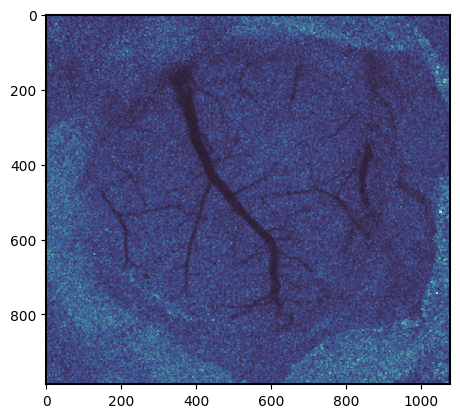

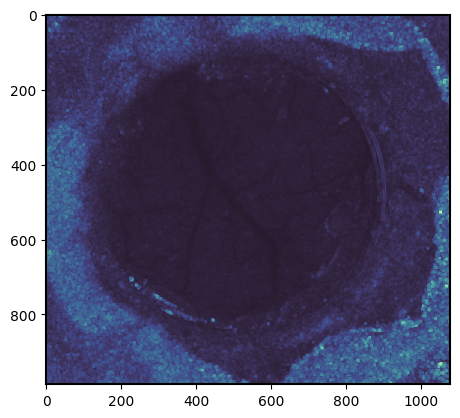

In [6]:
frame=9

# plt.imshow(data[frame])
# plt.show()
plt.imshow(data_LSCI[frame])
plt.show()
# plt.imshow(static_data[0])
# plt.show()
plt.imshow(static_data_LSCI[0])

# print(data_LSCI.dtype)
# print(np.min(data_LSCI), np.max(data_LSCI))
# print(data.shape)

## test 1/k^2 avec frames du 09-12

In [ ]:
# opend files
data_path = r"Z:\gGermain\2024-09-17\3_short\LSCI" #r"Z:\gGermain\2024-09-12\ch345_exp4ms_fps60\LSCI"
# data = create_npy_stack(data_path, data_path, 785)
# data = data-1000
# data_div = 1/(np.power())
# print(data.dtype)

data_save = 1/np.power(data.astype(np.float32), 2)
data_save = data_save/ np.mean(data_save, axis=0)
data_save = resample_pixel_value(data_save, 16).astype(np.uint16)
data_save = gaussian_filter(data_save, sigma=2)
save_as_tiff(data_save, data_path + "7")


# plt.imshow(data[4])
# plt.show()
# plt.imshow(1/data[4])
# plt.show()
print(np.min(data), np.max(data))

225it [00:04, 49.81it/s]


59 63790
